In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os 

In [3]:
DATASET_PATH = "archive1/myntradataset/"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


In [5]:
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=5000)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,8712,Unisex,Accessories,Eyewear,Sunglasses,Black,Winter,2016,Casual,Fastrack Unisex Black Sunglasses,8712.jpg
1,28691,Women,Apparel,Topwear,Kurtas,Black,Summer,2012,Ethnic,W Women Printed Black Kurta,28691.jpg
2,6618,Men,Apparel,Topwear,Shirts,Purple,Summer,2011,Casual,Spykar Men Purple and white Check Shirt,6618.jpg
3,3132,Men,Apparel,Topwear,Tshirts,Multi,Fall,2010,Casual,DUSG Men's Tadoba Organic Cotton Cappuccino T-...,3132.jpg
4,51008,Women,Apparel,Innerwear,Bra,Purple,Summer,2014,Casual,Enamor Purple Bra,51008.jpg
5,5252,Unisex,Accessories,Bags,Backpacks,Red,Summer,2017,Casual,Wildcraft Unisex Corporate Red Backpack,5252.jpg
6,8188,Men,Apparel,Topwear,Shirts,Purple,Summer,2011,Casual,Locomotive Men Solid Poplin Laidley Purple Shirts,8188.jpg
7,9000,Men,Footwear,Shoes,Casual Shoes,Brown,Fall,2011,Casual,Puma Men Archive Boot WTR Brown Casual Shoes,9000.jpg
8,40748,Women,Footwear,Flip Flops,Flip Flops,Pink,Winter,2012,Casual,Roxy Women Pink Flip Flops,40748.jpg
9,20895,Men,Footwear,Shoes,Casual Shoes,Orange,Fall,2011,Casual,Basics Men Orange Casual Shoes,20895.jpg


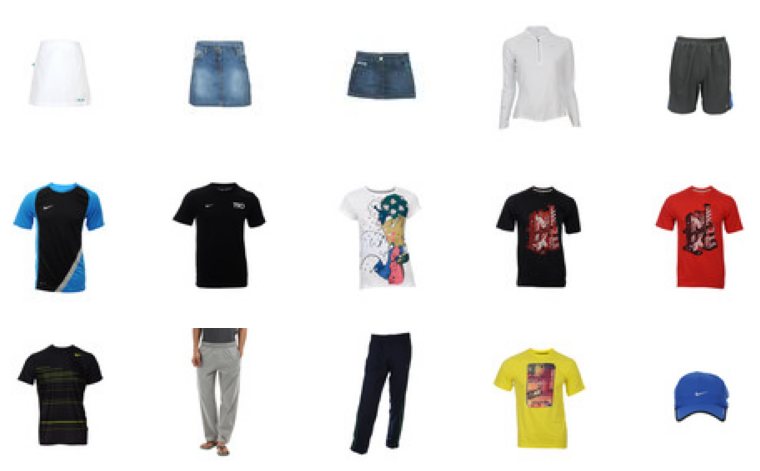

In [53]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_dir = 'archive1/myntradataset/images'
img_paths = [os.path.join(img_dir, img_file) for img_file in os.listdir(img_dir)]

plt.figure(1, figsize=(10, 10))

for i in range(15):
    img = mpimg.imread(img_paths[i])
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [7]:
from keras_preprocessing.image import ImageDataGenerator
batch_size=8
image_generator = ImageDataGenerator(
    validation_split=0.2
)

training_generator = image_generator.flow_from_dataframe(
    dataframe=df,
    directory=DATASET_PATH + "images",
    x_col="image",
    y_col="subCategory",
    target_size=(96,96),
    batch_size=batch_size,
    subset="training"
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe=df,
    directory=DATASET_PATH + "images",
    x_col="image",
    y_col="subCategory",
    target_size=(96,96),
    batch_size=8,
    subset="validation"
)

classes = len(training_generator.class_indices)

Found 4000 validated image filenames belonging to 36 classes.
Found 1000 validated image filenames belonging to 36 classes.


In [8]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.applications.mobilenet_v2 import MobileNetV2

# create the base pre-trained model
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                               

In [18]:
from math import ceil

model.fit_generator(
    generator=training_generator,
    #steps_per_epoch=ceil(0.8 * (df.size / batch_size)),

    validation_data=validation_generator,
    #validation_steps=ceil(0.2 * (df.size / batch_size)),

    epochs=10,
    verbose=1
)

#model.save('model.h5')

Epoch 1/10


C:\Users\keshav\AppData\Local\Temp\ipykernel_10948\357938274.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


500/500 [==============================] - 64s 129ms/step - loss: 0.3807 - accuracy: 0.9038 - val_loss: 0.5410 - val_accuracy: 0.8870
Epoch 2/10
500/500 [==============================] - 64s 128ms/step - loss: 0.2333 - accuracy: 0.9330 - val_loss: 0.6064 - val_accuracy: 0.8780
Epoch 3/10
500/500 [==============================] - 64s 129ms/step - loss: 0.2298 - accuracy: 0.9435 - val_loss: 0.6696 - val_accuracy: 0.8780
Epoch 4/10
500/500 [==============================] - 64s 128ms/step - loss: 0.1933 - accuracy: 0.9515 - val_loss: 0.6555 - val_accuracy: 0.8790
Epoch 5/10
500/500 [==============================] - 64s 128ms/step - loss: 0.1588 - accuracy: 0.9582 - val_loss: 0.7222 - val_accuracy: 0.8850
Epoch 6/10
500/500 [==============================] - 64s 128ms/step - loss: 0.1707 - accuracy: 0.9580 - val_loss: 0.9457 - val_accuracy: 0.8600
Epoch 7/10
500/500 [==============================] - 64s 128ms/step - loss: 0.1784 - accuracy: 0.9585 - val_loss: 0.8420 - val_accuracy: 0.8

In [15]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from keras.applications.vgg19 import VGG19

# create the base pre-trained model
base_model = VGG19(input_shape=(96, 96, 3), include_top=False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(classes, activation='softmax')(x)

# this is the model we will train
model_vgg = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_vgg.summary()

In [17]:
from math import ceil

model_vgg.fit_generator(
    generator=training_generator,
    #steps_per_epoch=ceil(0.8 * (df.size / batch_size)),

    validation_data=validation_generator,
    #validation_steps=ceil(0.2 * (df.size / batch_size)),

    epochs=10,
    verbose=1
)



Epoch 1/10


C:\Users\keshav\AppData\Local\Temp\ipykernel_10948\2006466863.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_vgg.fit_generator(


500/500 [==============================] - 21s 41ms/step - loss: 0.4153 - accuracy: 0.9047 - val_loss: 0.7531 - val_accuracy: 0.8490
Epoch 2/10
500/500 [==============================] - 21s 41ms/step - loss: 0.2632 - accuracy: 0.9295 - val_loss: 0.5208 - val_accuracy: 0.8940
Epoch 3/10
500/500 [==============================] - 20s 41ms/step - loss: 0.1899 - accuracy: 0.9498 - val_loss: 0.7318 - val_accuracy: 0.8580
Epoch 4/10
500/500 [==============================] - 20s 41ms/step - loss: 0.2180 - accuracy: 0.9528 - val_loss: 0.5826 - val_accuracy: 0.8890
Epoch 5/10
500/500 [==============================] - 21s 41ms/step - loss: 0.1422 - accuracy: 0.9645 - val_loss: 0.7532 - val_accuracy: 0.8900
Epoch 6/10
500/500 [==============================] - 21s 41ms/step - loss: 0.1892 - accuracy: 0.9603 - val_loss: 0.8408 - val_accuracy: 0.8910
Epoch 7/10
500/500 [==============================] - 65s 130ms/step - loss: 0.2356 - accuracy: 0.9470 - val_loss: 0.9204 - val_accuracy: 0.8750
Ep

In [49]:
from tensorflow.keras.applications import InceptionV3
# Create the base pre-trained model
base_model_inc = InceptionV3(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
x = base_model_inc.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(classes, activation='softmax')(x)
model_i = Model(inputs=base_model_inc.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model_inc.layers:
    layer.trainable = False

# Compile the model
model_i.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_i.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 32)   864         ['input_8[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 47, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 47, 47, 32)   0           ['batch_normalization[0][0]

In [50]:
model_i.fit_generator(
    generator=training_generator,
    #steps_per_epoch=ceil(0.8 * (df.size / batch_size)),
    validation_data=validation_generator,
    #validation_steps=ceil(0.2 * (df.size / batch_size)),
    epochs=10,
    verbose=1
)



Epoch 1/10


C:\Users\keshav\AppData\Local\Temp\ipykernel_10948\3253394318.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_i.fit_generator(


500/500 [==============================] - 24s 34ms/step - loss: 25.3980 - accuracy: 0.4507 - val_loss: 2.4725 - val_accuracy: 0.4470
Epoch 2/10
500/500 [==============================] - 15s 30ms/step - loss: 2.0174 - accuracy: 0.4902 - val_loss: 1.8352 - val_accuracy: 0.5570
Epoch 3/10
500/500 [==============================] - 14s 29ms/step - loss: 1.9243 - accuracy: 0.4950 - val_loss: 1.7298 - val_accuracy: 0.5470
Epoch 4/10
500/500 [==============================] - 14s 29ms/step - loss: 1.6987 - accuracy: 0.5360 - val_loss: 1.6959 - val_accuracy: 0.5240
Epoch 5/10
500/500 [==============================] - 15s 29ms/step - loss: 1.6421 - accuracy: 0.5428 - val_loss: 1.6200 - val_accuracy: 0.5590
Epoch 6/10
500/500 [==============================] - 15s 29ms/step - loss: 1.5676 - accuracy: 0.5580 - val_loss: 1.5713 - val_accuracy: 0.6010
Epoch 7/10
500/500 [==============================] - 15s 30ms/step - loss: 1.5614 - accuracy: 0.5605 - val_loss: 1.6853 - val_accuracy: 0.5450
Ep

In [45]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

model_res = ResNet50(input_shape=(96, 96, 3), include_top=False,weights='imagenet')

# add a global spatial average pooling layer
x = model_res.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=model_res.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in model_res.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_vgg.summary()

In [46]:
model.fit_generator(
    generator=training_generator,
    #steps_per_epoch=ceil(0.8 * (df.size / batch_size)),
    validation_data=validation_generator,
    #validation_steps=ceil(0.2 * (df.size / batch_size)),
    epochs=10,
    verbose=1
)



Epoch 1/10


C:\Users\keshav\AppData\Local\Temp\ipykernel_10948\1372510804.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


500/500 [==============================] - 18s 26ms/step - loss: 0.8948 - accuracy: 0.7987 - val_loss: 0.6068 - val_accuracy: 0.8490
Epoch 2/10
500/500 [==============================] - 11s 23ms/step - loss: 0.3584 - accuracy: 0.8898 - val_loss: 0.5817 - val_accuracy: 0.8640
Epoch 3/10
500/500 [==============================] - 11s 23ms/step - loss: 0.2674 - accuracy: 0.9208 - val_loss: 0.5726 - val_accuracy: 0.8690
Epoch 4/10
500/500 [==============================] - 12s 24ms/step - loss: 0.1520 - accuracy: 0.9477 - val_loss: 0.7207 - val_accuracy: 0.8530
Epoch 5/10
500/500 [==============================] - 12s 23ms/step - loss: 0.1522 - accuracy: 0.9525 - val_loss: 0.6505 - val_accuracy: 0.8780
Epoch 6/10
500/500 [==============================] - 12s 25ms/step - loss: 0.1016 - accuracy: 0.9672 - val_loss: 0.8005 - val_accuracy: 0.8670
Epoch 7/10
500/500 [==============================] - 12s 24ms/step - loss: 0.1050 - accuracy: 0.9647 - val_loss: 0.7893 - val_accuracy: 0.8620
Epo